In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import sqlite3
import os

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/database_1.db


Load received SQLite file: database.db.

In [3]:
conn = sqlite3.connect("/kaggle/input/database_1.db")
cur = conn.cursor()
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables_names = []
for table in res:
    command = "SELECT * FROM " + table[0]
    cur.execute(command)
    col_names = list(map(lambda x: x[0], cur.description))
    aux_dict = {table[0]: col_names}
    tables_names.append(aux_dict)

print('The tables and their columns of the database_1.db:')    
print(tables_names)

The tables and their columns of the database_1.db:
[{'data': ['id', 'x', 'y', 'z', 'connection_id']}, {'connection': ['id', 'name']}, {'additional_data': ['color_id', 'color_name']}]


Create Pandas DataFrame
with x, y, z, color_id and color_name for every record:

In [4]:
q = cur.execute("SELECT  x, y, z, connection_id, name FROM data LEFT JOIN connection ON data.connection_id = connection.id")
rows = q.fetchall()
df = pd.DataFrame(rows, columns = ['x', 'y', 'z', 'color_id', 'color_name'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101300 entries, 0 to 101299
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   x           101300 non-null  float64
 1   y           101300 non-null  object 
 2   z           101300 non-null  float64
 3   color_id    101300 non-null  int64  
 4   color_name  101200 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 3.9+ MB


All invalid record should be removed:

In [6]:
df.dropna(inplace = True)

x, y, z should be converted to floating-point format (if necessary), and
color_id to integers:


In [8]:
df['y'] = pd.to_numeric(df['y'], downcast="float")

Change color_name column to color:

In [9]:
df.rename(columns = {'color_name' : 'color'}, inplace = True)

List unique color values:

In [10]:
df['color'].unique()

array(['green', 'orange', 'yellow', 'red', 'black', 'blue'], dtype=object)

Leave only data with z = 100:

In [11]:
df = df[df['z'] == 100]

Remove red points with a distance from average red points’ position above 1 sigma:

In [13]:
sigma_red = np.std(df['x'][df.color == 'red'])
mean_red = df['x'][df.color == 'red'].mean()
threashold = mean_red + sigma_red
df = df[~((df['color'] == 'red') & (df['x'] > threashold))]

Make sure rows indices are consecutive integers (starting from 0):

In [14]:
df.reset_index(drop=True, inplace = True)

Save the remaining points in a HDF5 file with dataset ns1 containing columns: x, y,
color:

In [15]:
hdf = pd.HDFStore('hdf5_file.h5')
hdf.put('ns1', df[['x', 'y', 'color']], format = 'table', data_columns = True)

In [17]:
colors = {'red':'red', 'blue':'blue', 'green':'green'}

Plot data from the HDF5 file using scatter plot (with corresponding colors):

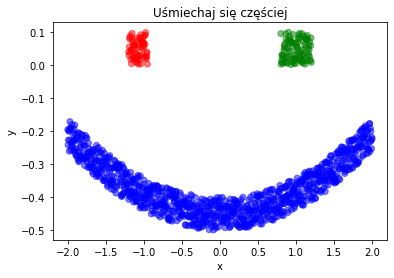

In [18]:
plt.scatter(hdf.get('/ns1')['x'],hdf.get('/ns1')['y'], c = hdf.get('/ns1')['color'].apply(lambda x: colors[x]), alpha=0.5)
plt.title('Uśmiechaj się częściej')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [19]:
hdf.close()